In [12]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage import filters
from matplotlib.patches import Rectangle
from matplotlib.gridspec import GridSpec
import pandas as pd

In [13]:
#Data files available from GitHub https://github.com/TeCSAR-UNCC/UNCC-ThermalFace

fnames = ['Charlotte-ThermalFace/S1.csv',
          'Charlotte-ThermalFace/S2.csv',
          'Charlotte-ThermalFace/S3.csv',
          'Charlotte-ThermalFace/S4.csv',
          'Charlotte-ThermalFace/S5.csv',
          'Charlotte-ThermalFace/S6.csv',
          'Charlotte-ThermalFace/S7.csv',
          'Charlotte-ThermalFace/S8.csv',
          'Charlotte-ThermalFace/S9.csv',
          'Charlotte-ThermalFace/S10.csv']

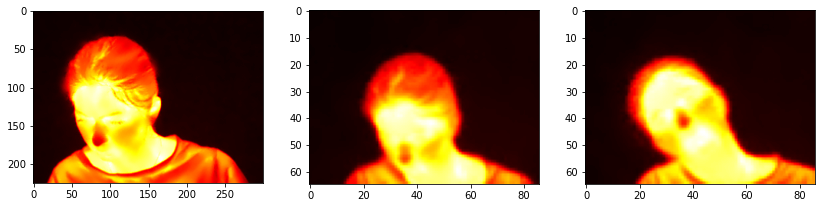

In [14]:
data = pd.read_csv(fnames[0])
data = data.dropna()

#Plotting example images
r_ids = np.random.choice(len(data),3)

f, axs = plt.subplots(1, 3, figsize=(14,7))
o = 0
z=[]
for i in r_ids:
    im = Image.open(fnames[0][:-4]+'/'+data['ID'].iloc[i]+'.tiff')
    imarray = (np.array(im) - 27315)/100
    axs[o].imshow(imarray, cmap='hot')
    o += 1
plt.show()
    

In [15]:
df = pd.DataFrame(columns=['RH','Airflow','env-temp','Sensation','mean_temp','max_temp','min_temp'])
for fname in fnames:
    data = pd.read_csv(fname)
    data = data.dropna()
    mean_data=np.zeros(data['ID'].shape[0])*np.nan
    max_data=np.zeros(data['ID'].shape[0])*np.nan
    min_data=np.zeros(data['ID'].shape[0])*np.nan

    for i in range(data['ID'].shape[0]):
        try:
            im = Image.open(fname[:-4]+'/'+data['ID'].iloc[i]+'.tiff')
            imarray = (np.array(im) - 27315)/100
            mean_data[i] = np.mean(imarray)
            max_data[i] = np.max(imarray)
            min_data[i] = np.min(imarray)
        except:
            pass
            #print(fname,i,fname[:-4]+'/'+data['ID'].iloc[i]+'.tiff')

    data['mean_temp'] = mean_data
    data['max_temp'] = max_data
    data['min_temp'] = min_data

    data = data[['RH','Airflow','env-temp','Sensation','mean_temp','max_temp','min_temp']]
    df = pd.concat([df,data])

#Cleaning up the collected data
df = df.dropna()
df['RH'] = pd.to_numeric(df['RH'])
df['Airflow'] = pd.to_numeric(df['Airflow'])
df['env-temp'] = pd.to_numeric(df['env-temp'])
df['Sensation'] = pd.to_numeric(df['Sensation'])
df['abs_diff_temp'] = np.abs(df['max_temp']-df['min_temp'])

In [16]:
df.describe()

,RH,Airflow,env-temp,Sensation,mean_temp,max_temp,min_temp,abs_diff_temp
count,2850.000000,2850.000000,2850.000000,2850.000000,2850.000000,2850.000000,2850.000000,2850.000000
mean,54.189599,0.068090,23.826125,0.113333,27.701368,36.120116,25.404716,10.715400
std,2.212162,0.173101,2.052238,0.815434,2.047530,0.880342,2.325122,1.940305
min,49.961111,0.000000,19.987667,-1.000000,10.459194,21.010000,7.680000,6.830000
25%,52.588889,0.000000,21.995000,0.000000,26.171583,35.670000,23.510000,9.092500
50%,54.377778,0.000000,23.722333,0.000000,27.740546,36.160000,25.470000,10.670000
75%,55.383333,0.000000,25.369792,1.000000,29.320751,36.590000,27.330000,12.157500
max,60.116667,0.508000,28.479778,2.000000,35.038892,42.720000,32.720000,14.900000


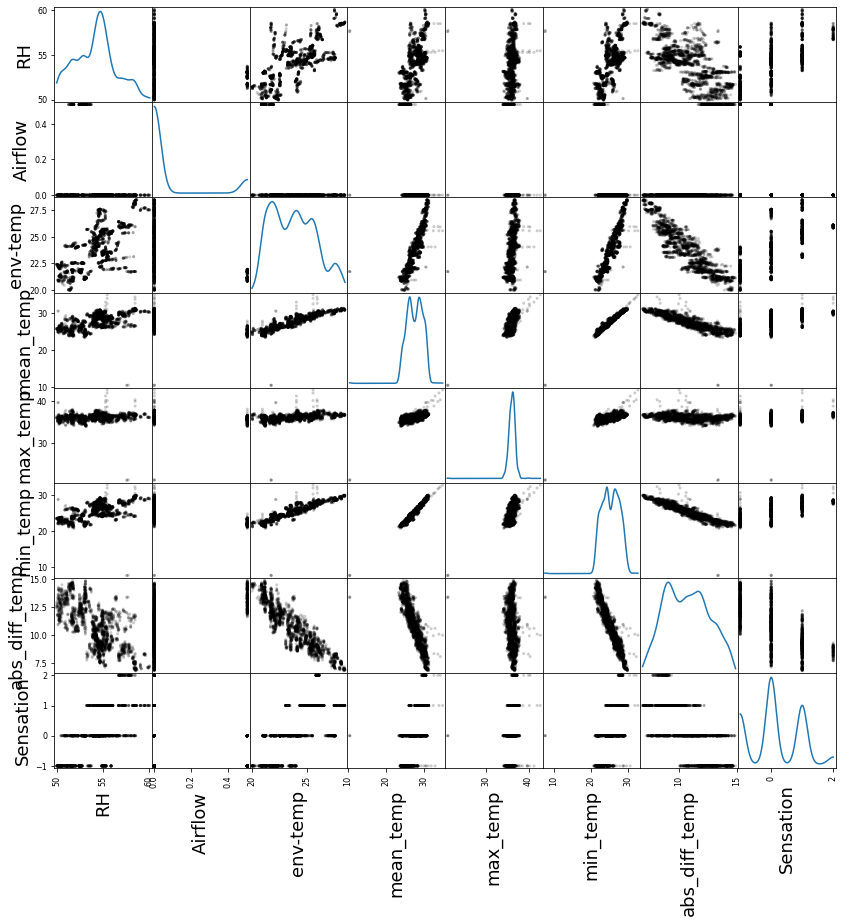

In [17]:
#Scatter correlation matrix
scatter_matrix = pd.plotting.scatter_matrix(df[['RH','Airflow','env-temp','mean_temp','max_temp','min_temp','abs_diff_temp','Sensation']],
                           color='k', alpha = 0.2, figsize = (14, 14), diagonal = 'kde')

for ax in scatter_matrix.ravel():
    ax.set_xlabel(ax.get_xlabel(), fontsize = 18, rotation = 90)
    ax.set_ylabel(ax.get_ylabel(), fontsize = 18, rotation = 90)

plt.savefig("scatter_matrix.png", dpi = 700)
plt.show()

In [18]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df[['env-temp', 'mean_temp', 'abs_diff_temp','RH','Airflow']]
y = df[['Sensation']].values

X_train, X_test, y_train, y_test = train_test_split(X, y.ravel(), test_size=0.33, random_state=42)

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y.ravel(), test_size=0.33, random_state=42)

# Train SVM classifier
clf = svm.SVC()

# 2. Use the classifier to fit your training data
clf.fit(X_train, y_train)

#The prediction results
pred_train = clf.predict(X_train)
pred_test = clf.predict(X_test)

#Calculate and print the training accuracy and testing accuracy. 
print("Training data accuracy: ")
print(clf.score(X_train, y_train)*100,'%')

#    2.2 Calculate the accuracy when classifying the test data
print("Testing data accuracy: ")
print(clf.score(X_test, y_test)*100,'%')

Training data accuracy: 
86.90413829229963 %
Testing data accuracy: 
84.9096705632306 %


In [19]:
#Leaving the relative humidity and airflow out of the model

X = df[['env-temp', 'mean_temp', 'abs_diff_temp']]#,'RH','Airflow']]
y = df[['Sensation']].values

X_train, X_test, y_train, y_test = train_test_split(X, y.ravel(), test_size=0.33, random_state=42)

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y.ravel(), test_size=0.33, random_state=42)

# Train SVM classifier
clf = svm.SVC()

# 2. Use the classifier to fit your training data
clf.fit(X_train, y_train)

#The prediction results
pred_train = clf.predict(X_train)
pred_test = clf.predict(X_test)

#Calculate and print the training accuracy and testing accuracy. 
print("Training data accuracy: ")
print(clf.score(X_train, y_train)*100,'%')

#    2.2 Calculate the accuracy when classifying the test data
print("Testing data accuracy: ")
print(clf.score(X_test, y_test)*100,'%')

Training data accuracy: 
75.79884756416972 %
Testing data accuracy: 
72.90116896918171 %
